In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Reshape
from tensorflow.keras import optimizers
import numpy as np
import gym
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
env = gym.make('CartPole-v0')

In [3]:
# Parameters
gamma = 0.99
lr = 1e-2
s_size = 4
a_size = 2
h_size = 8

In [4]:
def discount_rewards(r):
    """ take 1D float array of rewards and compute discounted reward """
    discounted_r = np.zeros_like(r)
    running_add = 0
    for t in reversed(range(0, r.size)):
        running_add = running_add * gamma + r[t]
        discounted_r[t] = running_add
    return discounted_r

In [5]:
tf.keras.backend.clear_session()

state_in = Input(batch_shape=[None, s_size], dtype=tf.float32)
reward_holder = Input(batch_shape=[None], dtype=tf.float32)

hidden = Dense(h_size, kernel_initializer='random_normal', activation='relu', use_bias=False)(state_in)
output = Dense(a_size, kernel_initializer='random_normal', activation='softmax', use_bias=False)(hidden)

@tf.function(experimental_relax_shapes=True)
def agent_loss(responsible_outputs, reward_holder):
    responsible_outputs = tf.dtypes.cast(responsible_outputs, dtype=tf.float32)
    reward_holder = tf.dtypes.cast(reward_holder, dtype=tf.float32)
    loss = -tf.reduce_mean(tf.math.log(responsible_outputs)*reward_holder)
    return loss

sgd = optimizers.Adam(lr=lr)
model = tf.keras.Model(inputs=state_in, outputs=output)
model.summary()
model.compile(loss=agent_loss,  optimizer=sgd)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 4)]               0         
_________________________________________________________________
dense (Dense)                (None, 8)                 32        
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 16        
Total params: 48
Trainable params: 48
Non-trainable params: 0
_________________________________________________________________


25.0


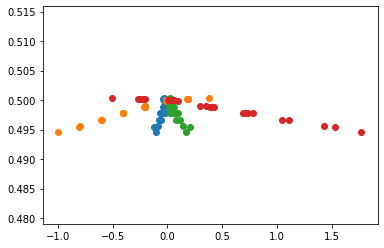

22.31


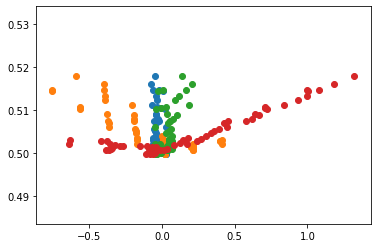

25.59


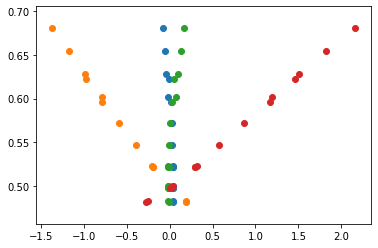

30.96


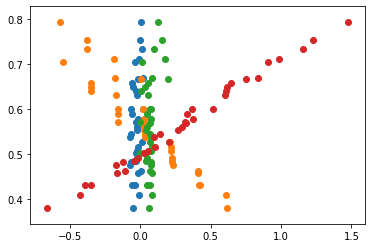

43.45


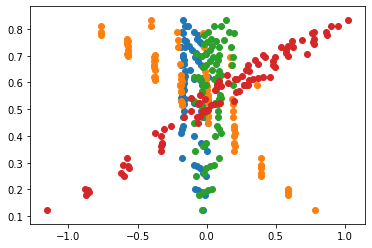

79.75


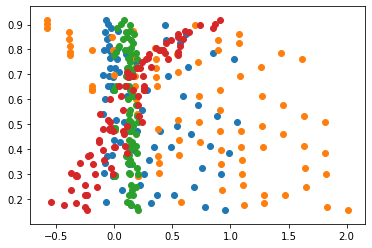

157.39


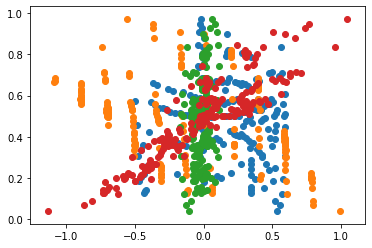

172.64


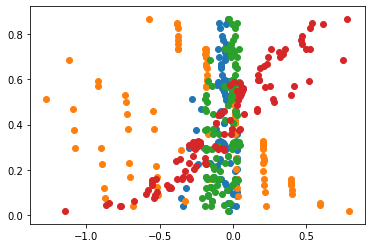

177.79


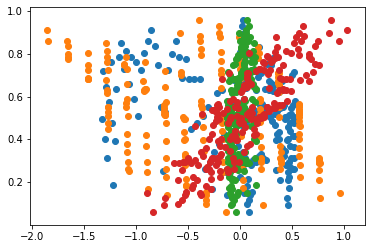

174.26


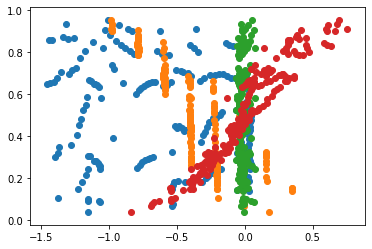

181.35


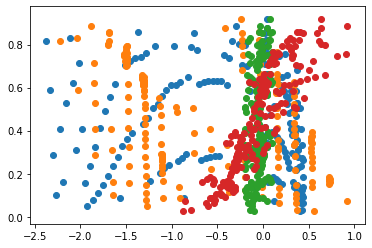

188.06


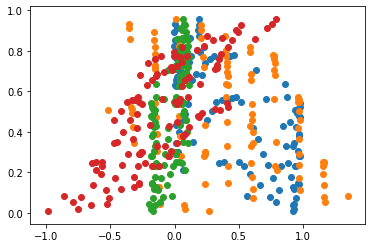

196.08


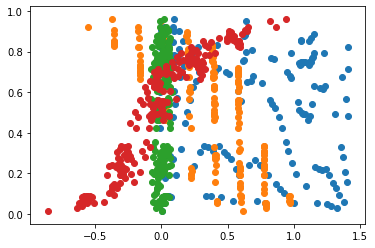

In [6]:
total_episodes = 5000 #Set total number of episodes to train agent on.
max_ep = 999
update_frequency = 5

# Launch the tensorflow graph
i = 0
total_reward = []
total_length = []

gradBuffer = model.trainable_variables
for ix, grad in enumerate(gradBuffer):
    gradBuffer[ix] = grad * 0

while i < total_episodes:
    s = env.reset()
    running_reward = 0
    ep_history = []
    for j in range(max_ep):
        #Probabilistically pick an action given our network outputs.
        s_in = np.array([s], dtype=np.float32)
        a_dist = np.array(model(s_in))[0]
        a = np.random.choice(a_dist, p=a_dist)
        a = np.argmax(a_dist == a)

        s1,r,d,_ = env.step(a) #Get our reward for taking an action given a bandit.
        ep_history.append([s,a,r,s1])
        s = s1
        running_reward += r
        if d == True:
            #Update the network.
            ep_history = np.array(ep_history)
            ep_history[:,2] = discount_rewards(ep_history[:,2])
            
            with tf.GradientTape() as tape:
                s_in = np.asarray(ep_history[:,0].tolist(), dtype=np.float32)
                out = model(s_in)
                
                n_values = 2
                a_in = np.eye(n_values)[ep_history[:,1].tolist()]
                a_in = np.array(a_in, dtype=np.float32)
                
                responsible_outputs = tf.reduce_sum(a_in * out, axis=1)
                
                rewards = tf.constant(np.array(ep_history[:,2], dtype=np.float32))
                
                model_loss = agent_loss(tf.constant(responsible_outputs), rewards)
                
            model_gradients = tape.gradient(model_loss, model.trainable_variables)

            for idx, grad in enumerate(model_gradients):
                gradBuffer[idx] += grad
            
            if i % update_frequency == 0 and i != 0:
                sgd.apply_gradients(zip(gradBuffer, model.trainable_variables))
                
                for ix, grad in enumerate(gradBuffer):
                    gradBuffer[ix] = grad * 0

            total_reward.append(running_reward)
            total_length.append(j)
            break


    #Update our running tally of scores.
    if i % 100 == 0:
        print(np.mean(total_reward[-100:]))
        states = np.asarray(np.array(ep_history)[:,0].tolist())
        plt.scatter(states[:,0],out[:,1])
        plt.scatter(states[:,1],out[:,1])
        plt.scatter(states[:,2],out[:,1])
        plt.scatter(states[:,3],out[:,1])
        plt.show()
    i += 1
    
    if np.mean(total_reward[-100:]) > 195:
        print(np.mean(total_reward[-100:]))
        states = np.asarray(np.array(ep_history)[:,0].tolist())
        plt.scatter(states[:,0],out[:,1])
        plt.scatter(states[:,1],out[:,1])
        plt.scatter(states[:,2],out[:,1])
        plt.scatter(states[:,3],out[:,1])
        plt.show()
        break

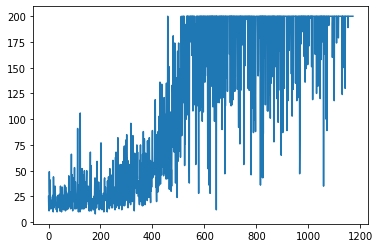

In [7]:
plt.plot(total_reward)